## 2) 스팸 메일 분류하기(Spam Detection)

이번 챕터에서는 캐글에서 제공하는 정상 메일과 스팸 메일이 섞여져 있는 스팸 메일 데이터를 가지고, 데이터에 대한 전처리를 진행하고 바닐라 RNN(Vanilla RNN)을 이용한 스팸 메일 분류기를 구현해보겠다.



### 1.스팸 메일 데이터에 대한 이해

다운로드 링크 : https://www.kaggle.com/uciml/sms-spam-collection-dataset



In [13]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv",
                           filename = "spam.csv")
data = pd.read_csv('spam.csv', encoding = 'latin1')

다운로드 받은 spam.csv 파일을 Pandas를 이용하여 data에 저장한다. 총 샘플의 수를 확인해보자.

In [3]:
print('총 샘플의 수 :', len(data))

총 샘플의 수 : 5572


총 5,572개의 샘플이 존재한다. 상위 5개의 샘플만 출력해보자.

In [4]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


스팸 메일 데이터 중에서 5개의 행만 출력해보았다. 이 데이터에는 총 5개의 열이 있는데, 여기서 Unnamed라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열이다. v1열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열이다. ham은 정상 메일을 의미하고, spam은 스팸 메일을 의미한다. v2열은 메일의 본문을 담고 있다.

레이블과 메일 내용이 담긴 v1열과 v2열만 필요하므로, Unnamed: 2, Unnamed: 3, Unnamed: 4 열은 삭제한다. 또한, v1열에 있는 ham과 spam 레이블을 각각 숫자 0과 1로 바꾸겠다. 다시 data에서 5개의 행만 출력해보겠다.

In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


불필요한 열이 제거되고, v1열의 값이 숫자로 변환된 것을 확인할 수 있다. 해당 data의 정보를 확인해보겠다.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


v1열은 정수형, v2열은 문자열 데이터를 갖고 있다. 혹시 Null 값을 가진 샘플이 있는지 isnull().values.any()로도 확인 가능하다.


In [7]:
data.isnull().values.any()

False

False는 별도의 Null 값은 없음을 의미한다. 초기 데이터에 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4' 열에는 NaN이 있었는데 해당 상태에서 수행하는 isnull().values.any()는 True를 리턴한다. Null 값이 없다면 혹시 데이터에 중복이 있지는 않은지 확인해보겠다.


In [8]:
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

총 5,572개의 샘플이 존재하는데 v2열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미이다. v1열은 0 또는 1의 값만을 가지므로 2가 출력되었다. 중복 샘플을 제거해보겠다.


In [9]:
data.drop_duplicates(subset = ['v2'], inplace = True) # v2 열에서 중복인 내용이 있다면 중복 제거


중복 샘플을 제거하였다. 정말 중복 샘플이 제거되었는지 전체 샘플 수를 확인한다.


In [10]:
print('총 샘플의 수 :', len(data))

총 샘플의 수 : 5169


총 샘플의 수가 5,572개에서 5,169개로 줄었다. 이제 스팸 메일 유무를 의미하는 레이블 값의 분포를 시각화해보겠다.


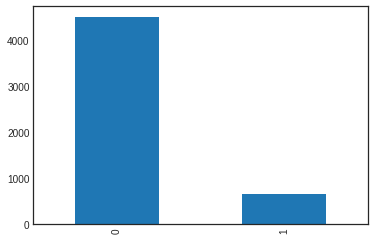

In [14]:
data['v1'].value_counts().plot(kind = 'bar');

레이블이 대부분 0에 편중되어 있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미한다. 수치로 확인해보겠다.


In [15]:
print(data.groupby('v1').size().reset_index(name = 'count'))

   v1  count
0   0   4516
1   1    653


레이블 0은 총 4,516개가 존재하고 1은 653개가 존재한다. 이제 X와 y를 분리한다. v2열을 X, v1열을 y로 저장한다.


In [16]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수 : {}'.format(len(X_data)))
print('레이블의 개수 : {}'.format(len(y_data)))

메일 본문의 개수 : 5169
레이블의 개수 : 5169


이제 메일의 본문은 X_data에, 각 메일의 본문에 대한 1과 0의 값을 가진 레이블은 y_data에 저장되었다. 개수는 둘 다 5,169개이다. 이제 케라스 토크나이저를 통해 토큰화와 정수 인코딩 과정을 수행해보겠다.


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장


In [18]:
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


sequences에는 X_data의 단어들이 각 단어에 맵핑되는 정수로 인코딩되어 저장되었다. 5,169개의 메일이 있으나, 5개의 메일만 출력해서 확인해보겠다.

각 메일에는 단어가 아니라 단어에 대한 인덱스가 부여된 것을 확인할 수 있다. 각 정수가 어떤 단어에 부여되었는지 확인해보자.


In [20]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'call': 17, 'that': 18, 'on': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'at': 27, 'or': 28, "i'm": 29, 'do': 30, 'be': 31, 'get': 32, 'will': 33, 'just': 34, 'if': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, 'gt': 42, 'lt': 43, '4': 44, 'how': 45, 'when': 46, 'go': 47, 'from': 48, 'ok': 49, 'out': 50, 'all': 51, 'what': 52, 'free': 53, 'know': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'come': 59, 'am': 60, 'was': 61, 'time': 62, 'its': 63, 'only': 64, 'day': 65, 'want': 66, 'love': 67, 'there': 68, 'he': 69, 'text': 70, 'send': 71, 'going': 72, 'one': 73, 'need': 74, 'by': 75, 'lor': 76, 'home': 77, 'as': 78, 'about': 79, 'still': 80, 'see': 81, 'txt': 82, 'back': 83, 'r': 84, 'stop': 85, 'da': 86, 'k': 87, 'today': 88, 'our': 89, "i'll": 90, 'dont': 91, 'reply': 

X_data에 존재하는 모든 단어와 부여된 인덱스를 리턴한다. 출력하면 위와 같은 결과가 나온다.

무수히 많은 단어가 출력되므로 출력 결과는 중간에 생략되었다. 위에서 부여된 각 정수는 각 단어의 빈도수가 높을수록 낮은 정수가 부여되었다. 다시 말해, 단어 i는 현재 전체 훈련 데이터에서 가장 빈도수가 높은 단어이다.

각 단어에 대한 등장 빈도수는 tokenizer.word_counts.items()를 출력해서 확인할 수 있다. 이를 응용하여 빈도수가 낮은 단어들이 훈련 데이터에서 얼마만큼의 비중을 차지하는지 확인해볼 수 있다. 등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼마만큼의 비율을 차지하며, 전체 훈련 데이터에서 등장 빈도로 얼마만큼의 비율을 차지하는지 확인해보겠다.


In [21]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합(vocabulary)에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)


등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지한다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않는다. 만약, 이러한 분석을 통해 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 케라스 토크나이저 선언 시에 단어 집합의 크기를 제한할 수 있었다는 사실을 기억하자. (정수 인코딩 챕터 참고) 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있을 것이다.

* tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

하지만 이번 실습에서는 별도로 단어 집합의 크기를 제한하진 않겠다. 이제 단어 집합의 크기를 vocab_size에 저장하겠다. 주의할 점은 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장해주어야 한다는 점이다.



In [22]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))

단어 집합의 크기 : 8921


단어 집합의 크기는 8,921이다. 이제 훈련 데이터와 테스트 데이터의 분리 비율을 정해보겠다. 여기서는 8:2로 정하겠다.


In [23]:
n_of_train = int(len(sequences) * 0.8)
n_of_test  = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :', n_of_train)
print('테스트 데이터의 개수 :', n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수 : 1034


앞서 확인하였는데 전체 메일의 개수는 5,169개이다. 이제 전체 메일 데이터에서 일부는 테스트 데이터로 분리해야 한다. 전체 데이터의 80%를 훈련용 데이터로, 20%를 테스트 데이터로 사용하고자 한다. 숫자를 계산해보았더니 훈련 데이터는 4,135개, 테스트 데이터는 1,034개를 쓰도록 한다. 아직은 단순히 숫자를 계산만 해본 것이고, 실제로 데이터를 나누지는 않았다.

직관적으로 변수를 기억하기 위해 X_data에 대해서 정수 인코딩된 결과인 sequences를 X_data로 변경하고, 전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 알아보도록 하겠다.



메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


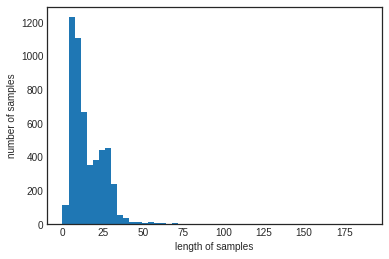

In [24]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data)) / len(X_data)))

plt.hist([len(s) for s in X_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 메일의 길이는 189이며, 전체 데이터의 길이 분포는 대체적으로 약 50이하의 길이를 가지는 것을 볼 수 있다.

In [25]:
max_len = 189
# 전체 데이터셋의 길이는 max_len으로 맞춘다.
data = pad_sequences(X_data, maxlen = max_len)
print('훈련 데이터의 크기(shape):', data.shape)

훈련 데이터의 크기(shape): (5169, 189)


maxlen에는 가장 긴 메일의 길이였던 189이라는 숫자를 넣었다. 이는 5,169개의 X_data의 길이를 전부 189로 바꾼다. 189보다 길이가 짧은 메일 샘플은 전부 숫자 0이 패딩되어 189의 길이를 가지게 된다.

이제 X_data는 5,169 x 189의 크기를 갖게 된다. 헷갈리지 말아야할 것은 아직 X_train과 X_test를 분리하지 않았다는 것이다. 2챕터의 데이터의 분리 챕터에서 배웠던 방법 중 하나로 훈련 데이터와 테스트 데이터를 분리해본다.



In [26]:
X_test = data[n_of_train:] # X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) # y_data 데이터 중에서 뒤의 1034개의 데이터만 저장

X_train = data[:n_of_train] # X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) # y_data 데이터 중에서 앞의 4135개의 데이터만 저장


이제 모델을 설계해보겠다.


### 2.RNN으로 스팸 메일 분류하기

이제 바닐라 RNN을 이용하여 스팸 메일 분류기를 만들어보도록 하겠다.


In [27]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [29]:
hist = model.fit(X_train, y_train,
                 epochs = 4, 
                 batch_size = 64,
                 validation_split = 0.2)


Epoch 1/4
52/52 [==============================] - 3s 37ms/step - loss: 0.5167 - acc: 0.7667 - val_loss: 0.2100 - val_acc: 0.9359
Epoch 2/4
52/52 [==============================] - 2s 35ms/step - loss: 0.1445 - acc: 0.9658 - val_loss: 0.0884 - val_acc: 0.9710
Epoch 3/4
52/52 [==============================] - 2s 37ms/step - loss: 0.0642 - acc: 0.9834 - val_loss: 0.0726 - val_acc: 0.9722
Epoch 4/4
52/52 [==============================] - 2s 36ms/step - loss: 0.0349 - acc: 0.9920 - val_loss: 0.0576 - val_acc: 0.9794


Embedding()은 두 개의 인자를 받는다. 단어 집합의 크기, 임베딩 벡터의 차원이다. 이진 분류 문제이므로 마지막 출력층에는 1개의 뉴런과 활성화 함수로 시그모이드 함수를 사용한다. 손실 함수로는 binary_crossentropy를 사용한다.

validation_split = 0.2을 주어서 훈련 데이터의 20%를 검증 데이터로 나누고, 검증 데이터를 보면서 훈련이 제대로 되고 있는지 확인해보겠다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용된다. 총 4번 학습한다.

이제 테스트 데이터에 대해서 정확도를 확인해보겠다.


In [31]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 7ms/step - loss: 0.0538 - acc: 0.9855

 테스트 정확도: 0.9855


정확도가 98%가 나왔다. 이번 실습에서는 훈련 데이터와 검증 데이터에 대해서 같이 정확도를 확인하면서 훈련하였으므로, 이를 비교하여 그래프로 시각화해보겠다.


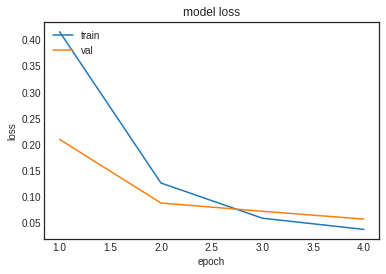

In [32]:
epochs = range(1, len(hist.history['acc']) + 1)

plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

이번 실습 데이터는 데이터의 양이 적어 과적합이 빠르게 시작되므로, 검증 데이터에 대한 오차가 증가하기 시작하는 시점의 바로 직전인 에포크 3~4 정도가 적당하다. 이 데이터는 에포크 5를 넘어가기 시작하면 검증 데이터의 오차가 증가하는 경향이 있다.
